## 04. PyTorch Custom Datasets

=> get own data into pytorch

### 0. Importing and setting up

In [1]:
import torch
from torch import nn

In [2]:
device = "gpu" if torch.cuda.is_available() \
    else "mps" if torch.backends.mps.is_built() else "cpu"
device

'mps'

### 1. Get data

- `Food-101 Dataset:` https://data.vision.ee.ethz.ch/cvl/datasets_extra/food-101/
    - 101 different classes of food
    - 1000 images per class (750 training)

#### => use a subset of the Food-101 dataset
- use 3 classes of food 
- obly 10% of the images (75 training)

In [3]:
import requests
import zipfile
from pathlib import Path

In [4]:
data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi"

if image_path.is_dir():
    print(image_path, " directory already exists...")
else:
    print(image_path, " does not exist, creating...")
    image_path.mkdir(parents=True, exist_ok=True)

data/pizza_steak_sushi  directory already exists...


In [5]:
with open(data_path / "pizza_steak_sushi.zip", "wb") as f:
    request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
    print("Downloading...")
    f.write(request.content)

# unzip the file data
with zipfile.ZipFile(data_path / "pizza_steak_sushi.zip", "r") as zip_ref:
    print("Unzipping...")
    zip_ref.extractall(image_path)

Downloading...
Unzipping...


### 2. Data preparation and data exploration

In [6]:
import os

def walk_through_dir(dir_path):
    """ walks through dir_path returning its contents """
    # directory tree generator
    for dirpath, dirnames, filenames in os.walk(dir_path):
        print("There are", len(dirnames), "directories and ", len(filenames), " images in", dirpath)


In [7]:
walk_through_dir(image_path)

There are 2 directories and  0  images in data/pizza_steak_sushi
There are 3 directories and  0  images in data/pizza_steak_sushi/test
There are 0 directories and  19  images in data/pizza_steak_sushi/test/steak
There are 0 directories and  31  images in data/pizza_steak_sushi/test/sushi
There are 0 directories and  25  images in data/pizza_steak_sushi/test/pizza
There are 3 directories and  0  images in data/pizza_steak_sushi/train
There are 0 directories and  75  images in data/pizza_steak_sushi/train/steak
There are 0 directories and  72  images in data/pizza_steak_sushi/train/sushi
There are 0 directories and  78  images in data/pizza_steak_sushi/train/pizza


- `pizza_steak_sushi` -> overall dataset folder
    - `train`   -> training images
        - `pizza`   -> class name as folder name
        - `steak`
        - `sushi`
    - `test`    -> testing images

In [8]:
# set up train and testing paths
train_dir = image_path / "train"
test_dir = image_path / "test"

train_dir, test_dir

(PosixPath('data/pizza_steak_sushi/train'),
 PosixPath('data/pizza_steak_sushi/test'))

#### 2.1 Visualize images

- (1) get all of the image paths
- (2) pick a random image path using Python's `random.choice()`
- (3) get the image class name using `pathlib.Path.parent.stem`
- (4) open the image using Python `PIL(pillow)`
- (5) show image and print metadata

In [9]:
# visualize random image
import random
from PIL import Image

# get all the image path
image_path_list = list(image_path.glob("*/*/*.jpg"))
image_path_list[:5]

[PosixPath('data/pizza_steak_sushi/test/steak/296375.jpg'),
 PosixPath('data/pizza_steak_sushi/test/steak/673127.jpg'),
 PosixPath('data/pizza_steak_sushi/test/steak/894825.jpg'),
 PosixPath('data/pizza_steak_sushi/test/steak/1868005.jpg'),
 PosixPath('data/pizza_steak_sushi/test/steak/27415.jpg')]

Random image path is: data/pizza_steak_sushi/test/sushi/479711.jpg
Image class is: sushi
Image width is: 512
Image height is: 512


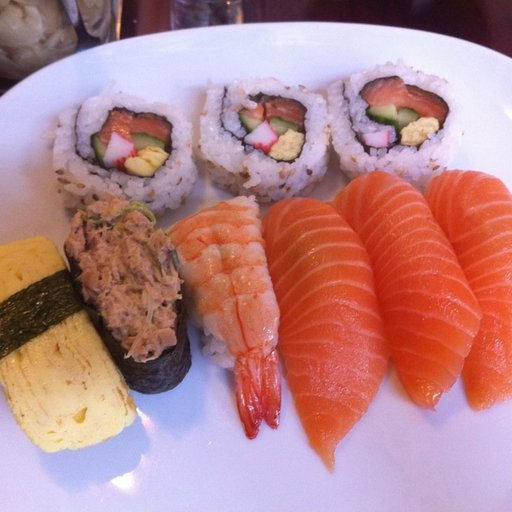

In [10]:
# pick a random image
random_image_path = random.choice(image_path_list)

# get class
image_class = random_image_path.parent.stem

# open image
img = Image.open(random_image_path)

# print metadata
print("Random image path is:", random_image_path)
print("Image class is:", image_class)
print("Image width is:", img.width)
print("Image height is:", img.height)

img

(-0.5, 511.5, 511.5, -0.5)

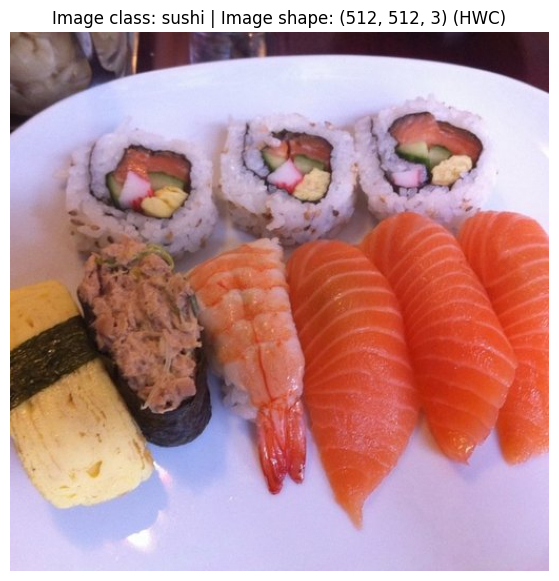

In [11]:
import numpy as np
import matplotlib.pyplot as plt

# turn the image into an array
img_array = np.array(img)

# plot the image with matplotlib
plt.figure(figsize=(10,7))
plt.imshow(img_array)
plt.title(f"Image class: {image_class} | Image shape: {img_array.shape} (HWC)")
plt.axis(False)

### 3. Transform data

- (1) turn target data into tensors
- (2) turn it into a `torch.utils.data.Dataset` and then `torch.utils.data.DataLoader`

In [12]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

#### 3.1 Transform data with `torchvision.transform`

=> https://pytorch.org/vision/stable/auto_examples/plot_transforms.html#sphx-glr-auto-examples-plot-transforms-py

In [13]:
# write a transform for image
data_transform = transforms.Compose([
    # resize image to 64 x 64
    transforms.Resize(size=(64, 64)),
    # flip the image randomly on the horizontal?
    transforms.RandomHorizontalFlip(p = 0.5),
    # tnru into a torch tensor
    transforms.ToTensor()
])

In [14]:
data_transform(img).shape

torch.Size([3, 64, 64])

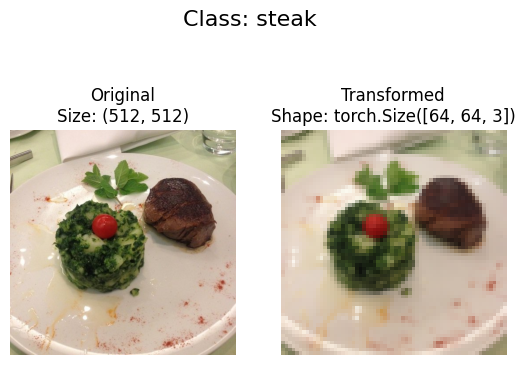

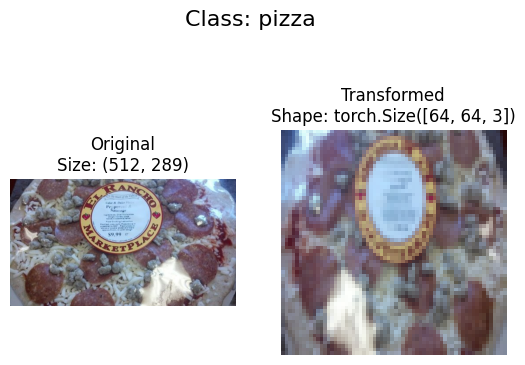

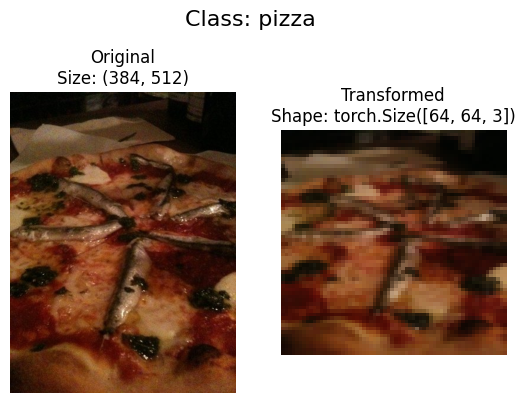

In [15]:
def plot_transform_img(image_path:list, transform, n=3, seed=None):
    """
    select random images from a path of images and load/transform them
    then, plots the original VS the transformed version
    """

    if seed:
        random.seed(seed)
    random_img_path = random.sample(image_path, k=n)

    for image_path in random_img_path:
        with Image.open(image_path) as f:
            fig, ax = plt.subplots(nrows=1, ncols=2)
            ax[0].imshow(f)
            ax[0].set_title(f"Original\nSize: {f.size}")
            ax[0].axis(False)

            # transform and plot
            # need to change the shape to color channel first
            transform_img = transform(f).permute(1, 2, 0)
            ax[1].imshow(transform_img)
            ax[1].set_title(f"Transformed\nShape: {transform_img.shape}")
            ax[1].axis(False)

            fig.suptitle(f"Class: {image_path.parent.stem}", fontsize=16)

plot_transform_img(image_path_list, data_transform, n=3, seed=None)

### 4. Option 1: Loading image data using `ImageFolder`

#### => can load image classification data using `torchvision.datasets.ImageFolder`

In [16]:
# using imagefolder to create dataset(s)
from torchvision import datasets
train_data = datasets.ImageFolder(root=train_dir,
                                  transform=data_transform, # trasform for the data
                                  target_transform=None)    # trasform for the label

test_data = datasets.ImageFolder(root=test_dir,
                                 transform=data_transform,
                                 target_transform=None)
train_data, test_data

(Dataset ImageFolder
     Number of datapoints: 225
     Root location: data/pizza_steak_sushi/train
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=warn)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ),
 Dataset ImageFolder
     Number of datapoints: 75
     Root location: data/pizza_steak_sushi/test
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=warn)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ))

In [17]:
# get a list of class names
class_names = train_data.classes
class_names

['pizza', 'steak', 'sushi']

In [18]:
# get class name as dict
class_dict = train_data.class_to_idx
class_dict

{'pizza': 0, 'steak': 1, 'sushi': 2}

In [19]:
len(train_data), len(test_data)

(225, 75)

In [20]:
train_data.samples[:10]

[('data/pizza_steak_sushi/train/pizza/1008844.jpg', 0),
 ('data/pizza_steak_sushi/train/pizza/1033251.jpg', 0),
 ('data/pizza_steak_sushi/train/pizza/1044789.jpg', 0),
 ('data/pizza_steak_sushi/train/pizza/1089334.jpg', 0),
 ('data/pizza_steak_sushi/train/pizza/1105700.jpg', 0),
 ('data/pizza_steak_sushi/train/pizza/12301.jpg', 0),
 ('data/pizza_steak_sushi/train/pizza/1285298.jpg', 0),
 ('data/pizza_steak_sushi/train/pizza/138855.jpg', 0),
 ('data/pizza_steak_sushi/train/pizza/1412034.jpg', 0),
 ('data/pizza_steak_sushi/train/pizza/1524655.jpg', 0)]

In [21]:
img, label = train_data[0][0], train_data[0][1]
print(f"Image tensor:\n {img}")
print(f"Image shape: {img.shape}")
print(f"Image datatype: {img.dtype}")
print(f"Image label: {label}")
print(f"Label datatype: {type(label)}")

Image tensor:
 tensor([[[0.1176, 0.1216, 0.1255,  ..., 0.0980, 0.1020, 0.1137],
         [0.1294, 0.1294, 0.1294,  ..., 0.0980, 0.0980, 0.1059],
         [0.1333, 0.1333, 0.1333,  ..., 0.0941, 0.0980, 0.1020],
         ...,
         [0.1686, 0.1647, 0.1686,  ..., 0.1255, 0.1098, 0.1098],
         [0.1686, 0.1647, 0.1686,  ..., 0.1098, 0.0941, 0.0902],
         [0.1647, 0.1647, 0.1686,  ..., 0.0980, 0.0863, 0.0863]],

        [[0.0588, 0.0588, 0.0588,  ..., 0.0745, 0.0706, 0.0745],
         [0.0627, 0.0627, 0.0627,  ..., 0.0745, 0.0706, 0.0745],
         [0.0706, 0.0706, 0.0706,  ..., 0.0745, 0.0745, 0.0706],
         ...,
         [0.2392, 0.2392, 0.2510,  ..., 0.1373, 0.1333, 0.1255],
         [0.2314, 0.2392, 0.2510,  ..., 0.1255, 0.1176, 0.1098],
         [0.2275, 0.2353, 0.2431,  ..., 0.1137, 0.1059, 0.1020]],

        [[0.0196, 0.0196, 0.0157,  ..., 0.0902, 0.0902, 0.0941],
         [0.0196, 0.0157, 0.0196,  ..., 0.0902, 0.0863, 0.0902],
         [0.0196, 0.0157, 0.0157,  ..., 0.0

Original image shape: torch.Size([3, 64, 64])
Image permute shape: torch.Size([64, 64, 3])


Text(0.5, 1.0, 'pizza')

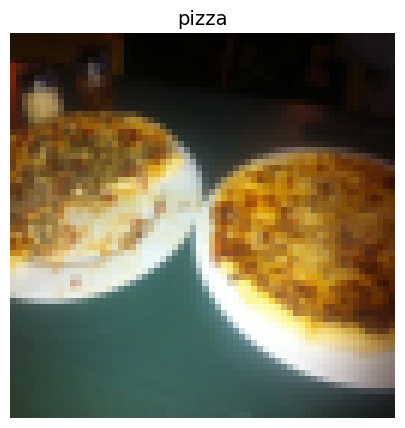

In [22]:
# rearrange the order dimension
img_permute = img.permute(1,2,0)

print(f"Original image shape: {img.shape}")
print(f"Image permute shape: {img_permute.shape}")

plt.figure(figsize=(8,5))
plt.imshow(img_permute)
plt.axis(False)
plt.title(class_names[label], fontsize=14)

#### 4.1 Turn loaded images into `DataLoader`

=> `DataLoader` -> help to turn `Dataset` into iterables and can customise the `batch_size`

In [23]:
import os
os.cpu_count()

10

In [24]:
# turn train and test datasets into DataLoader
from torch.utils.data import DataLoader
train_dataloader = DataLoader(train_data,
                              batch_size=1,
                              num_workers=os.cpu_count(),   # number of cpu core
                              shuffle=True)
test_dataloader = DataLoader(test_data,
                             batch_size=1,
                             num_workers=os.cpu_count(),
                             shuffle=False)

train_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x156c26d10>,
 <torch.utils.data.dataloader.DataLoader at 0x156c279a0>)

In [25]:
img, label = next(iter(train_dataloader))

print(f"Image shape: {img.shape} -> [batch size, color channel, height, width]")
print(f"Label shape: {label.shape}")

Image shape: torch.Size([1, 3, 64, 64]) -> [batch size, color channel, height, width]
Label shape: torch.Size([1])


### 5. Option 2: Load image data with a custom `Dataset`

- (1) want to be able to load images from file
- (2) want to be able to get class names from the Dataset
- (3) want to be able to get classes as dictionary from the Dataset

#### Pros:
- can create a `Dataset` out of almost anything
- not limited to PyTorch pre-built `Dataset` functions

#### Cons:
- enven though could create `Dataset` out of almost anything -> doesn't mean it will work...
- using a custom `Dataset` often results in writing more code, which could be prone to errors or performance issues


In [26]:
import os
import pathlib
import torch

from PIL import Image
from torch.utils.data import Dataset
from torchvision import transforms
from typing import Tuple, Dict, List

In [27]:
# instance of torchvision.datasets.ImageFolder()
train_data.classes, test_data.class_to_idx

(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})

#### 5.1 Create a helper function to get class names

- (1) get the class names using `os.scandir()` to traverse a target directory (ideally the directory is in standard image classification format)
- (2) raise an error if the class names aren't found (sth wrong with the directory structure)
- (3) turn the class names into a dict and a list and return them

In [28]:
target_dictionary = train_dir
print(f"Target dir: {target_dictionary}")

list(os.scandir(target_dictionary))

Target dir: data/pizza_steak_sushi/train


[<DirEntry 'steak'>, <DirEntry 'sushi'>, <DirEntry 'pizza'>]

In [29]:
# get the class names
class_name_found = sorted([entry.name for entry in list(os.scandir(target_dictionary))])
class_name_found

['pizza', 'steak', 'sushi']

In [30]:
def find_classes(directory: str) -> Tuple[List[str], Dict[str, int]]:
    """ find the class folder names in a target dictory """
    # get the class names by sacnning the target directory
    classes = sorted([entry.name for entry in os.scandir(directory) if entry.is_dir()])

    #  raise an error if class name could not be found
    if not classes:
        raise FileNotFoundError("Could not find any classes in", directory)

    # create a dict of index labels
    class_to_idx = {class_name: i for i, class_name in enumerate(classes)}
    
    return classes, class_to_idx

In [31]:
find_classes(target_dictionary)

(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})

#### 5.2 Create a custom `Dataset` to replicate `ImageFolder`

- (1) subclass `torch.utils.data.Dataset`
- (2) init subclass with a target directory as well as a transform
- (3) create several attributes:
    - paths -> paths of images
    - transform -> transform like to use
    - classes -> a list of the target classes
    - class_to_idx -> a dict of the target classes mapped to integer labels
- (4) create a function to `load_images()` -> oprn an image
- (5) overwrite the `__len()__` method to return the length of dataset
- (6) overwrite the `__getitem()__` method to return a given sample when passed an index

In [32]:
from torch.utils.data import Dataset

# subclass torch.utils.data.Dataset
class ImageFolderCustom(Dataset):
    # initialize
    def __init__(self, targ_dir: str, transform=None):
        # create class attributes
        self.paths = list(pathlib.Path(targ_dir).glob("*/*.jpg"))
        # setup transform
        self.transforms = transform
        # create classes and class_to_idx attributes
        self.classes, self.class_to_idx = find_classes(targ_dir)
    
    # create a function to load images
    def load_image(self, index: int) -> Image.Image:
        """ opens an image via a path and returns it """
        image_path = self.paths[index]
        return Image.open(image_path)

    # overwrite __len__()
    def __len__(self) -> int:
        """ returns the total number of samples """
        return len(self.paths)
    
    # overwrite __getitem__() to return a particular sample
    def __getitem__(self, index:int) -> Tuple[torch.Tensor, int]:
        """ returns one sample of data, data and label (X, y) """
        img = self.load_image(index)
        # data_folder/class_name/image.jpg
        class_name = self.paths[index].parent.name
        class_idx = self.class_to_idx[class_name]

        # transform if necessary
        if self.transforms:
            return self.transforms(img), class_idx
        else:
            return img, class_idx

In [33]:
# create a transform
train_transforms = transforms.Compose([
    transforms.Resize(size=(64,64)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor()
])

test_transforms = transforms.Compose([
    transforms.Resize(size=(64,64)),
    transforms.ToTensor()
])

In [34]:
# test out ImageFolderCustom
train_data_custom = ImageFolderCustom(targ_dir=train_dir,
                                      transform=train_transforms)
test_data_custom = ImageFolderCustom(targ_dir=test_dir,
                                     transform=test_transforms)

train_data_custom, test_data_custom

(<__main__.ImageFolderCustom at 0x156c4ea70>,
 <__main__.ImageFolderCustom at 0x156c26cb0>)

In [35]:
print(train_data_custom.classes)
print(train_data_custom.class_to_idx)

['pizza', 'steak', 'sushi']
{'pizza': 0, 'steak': 1, 'sushi': 2}


In [36]:
# check for equality
print(train_data_custom.classes == train_data.classes)
print(test_data_custom.classes == test_data.classes)

True
True


#### 5.3 Create a function to display random images

- (1) take in a `Dataset` and a number of other parameters such as class names and how many images to visualize
- (2) to prevent the display getting out of hand, lets cap the number of images to see at 10
- (3) set the random seed for reproducibility
- (4) get a list of random sample indexes from the target dataset
- (5) setup a matplotlib plot
- (6) loop through the random sample images and plot them with matplotlib
- (7) make sure the dimensions of images line up woth matplotlib (HWC)

In [37]:
# create a function to take in a dataset
def display_random_images(dataset: torch.utils.data.Dataset,
                          classes: List[str] = None,
                          n: int = 10,      # number of images to display
                          display_shape: bool = True,
                          seed: int = None):
    # adjust display if n is too high
    if n > 10:
        n = 10
        display_shape = False
        print("For display purposes, n should be < 10, set to 10 and remove shape display.")
    
    # set the seed
    if seed:
        random.seed(seed)
    
    # get random n sample indexes -> a range of the length of the dataset
    random_idx = random.sample(range(len(dataset)), k=n)

    # set up plot
    plt.figure(figsize=(16,8))

    # loop through random indexes and plot them with matplotlib
    for i, targ_sample in enumerate(random_idx):
        targ_img, targ_label = dataset[targ_sample][0], dataset[targ_sample][1]

        # adjust tensor dimensions for ploting
        targ_img_adjust = targ_img.permute(1, 2, 0)     # CHW -> HWC

        # plot
        plt.subplot(1, n, i+1)
        plt.imshow(targ_img_adjust)
        plt.axis(False)
        if classes:
            title = "Class: " + classes[targ_label]
            if display_shape:
                title = title + "\nShape: " + str(targ_img_adjust.shape)
        
        plt.title(title)

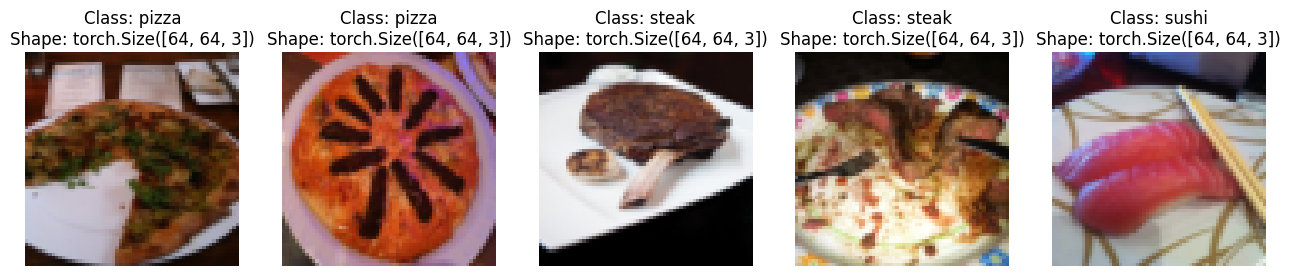

In [38]:
display_random_images(train_data, n=5,classes=class_names,seed=None)

For display purposes, n should be < 10, set to 10 and remove shape display.


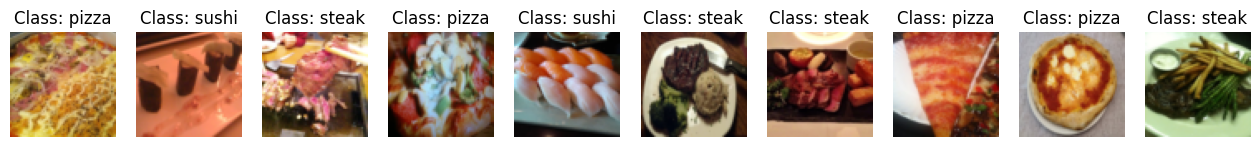

In [39]:
# display random images from the ImageFolderCustom Dataset
display_random_images(train_data_custom, n=15,classes=class_names,seed=None)

#### 5.4 Turn custom loaded images into `DataLoader's`

In [40]:
from torch.utils.data import DataLoader
BATCH_SIZE = 1
train_dataloader_custom = DataLoader(train_data_custom,
                                     batch_size=BATCH_SIZE,
                                     shuffle=True)
test_dataloader_custom = DataLoader(test_data_custom,
                                    batch_size=BATCH_SIZE,
                                    shuffle=False)

train_dataloader_custom, test_dataloader_custom

(<torch.utils.data.dataloader.DataLoader at 0x156b1afb0>,
 <torch.utils.data.dataloader.DataLoader at 0x156b1ada0>)

In [41]:
# get image and label from custom dataloader
img_custom, label_custom = next(iter(train_dataloader_custom))

img_custom.shape, label_custom.shape

(torch.Size([1, 3, 64, 64]), torch.Size([1]))

### 6. Other forms of transforms (data augmentation)

**data augmentation** -> the process of artificially adding diversity to training data

=> in the case of image data -> may apply various image transformations to the training images

-> E.g. rotate / shift / zoom / crop / replace / shear ...

=> hopefully results in a model that is more generalizable to unseen data

-> https://pytorch.org/blog/how-to-train-state-of-the-art-models-using-torchvision-latest-primitives/


In [42]:
# look at trivialaugment
train_trivialaugment = transforms.Compose([
    transforms.Resize(size=(224,224)),
    # how instance want the sugmentation to happen
    transforms.TrivialAugmentWide(num_magnitude_bins=31),
    transforms.ToTensor()
])

# Don't need to perform augmentation on the test data
test_transforms = transforms.Compose([
    transforms.Resize((224, 224)), 
    transforms.ToTensor()
])

In [43]:
# get all image paths
image_path_list = list(image_path.glob("*/*/*.jpg"))
image_path_list[:10]

[PosixPath('data/pizza_steak_sushi/test/steak/296375.jpg'),
 PosixPath('data/pizza_steak_sushi/test/steak/673127.jpg'),
 PosixPath('data/pizza_steak_sushi/test/steak/894825.jpg'),
 PosixPath('data/pizza_steak_sushi/test/steak/1868005.jpg'),
 PosixPath('data/pizza_steak_sushi/test/steak/27415.jpg'),
 PosixPath('data/pizza_steak_sushi/test/steak/1016217.jpg'),
 PosixPath('data/pizza_steak_sushi/test/steak/1285886.jpg'),
 PosixPath('data/pizza_steak_sushi/test/steak/502076.jpg'),
 PosixPath('data/pizza_steak_sushi/test/steak/3424937.jpg'),
 PosixPath('data/pizza_steak_sushi/test/steak/690177.jpg')]

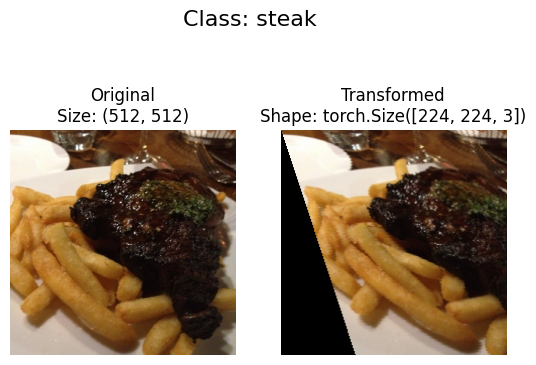

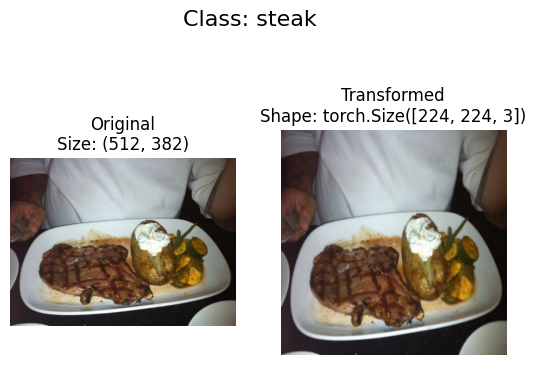

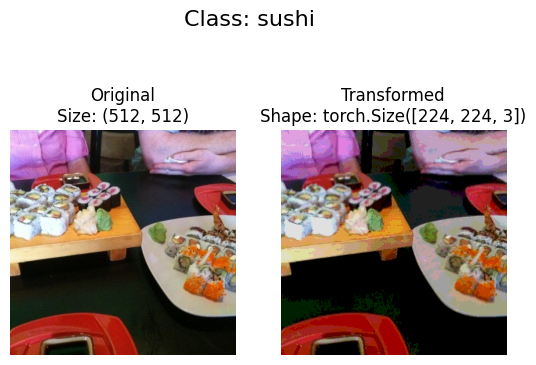

In [44]:
# plot random transformed images
plot_transform_img(image_path_list, train_trivialaugment, n=3, seed=None)

### 7. Model 0: TinyVGG without data augmentation

#### 7.1 Create transform and load data for model 0

In [45]:
# create a simple transform
simple_transform = transforms.Compose([ 
    transforms.Resize((64, 64)),
    transforms.ToTensor()
])

In [46]:
# load a simple transform data
from torchvision import datasets
train_data_simple = datasets.ImageFolder(root=train_dir,
                                         transform=simple_transform)
test_data_simple = datasets.ImageFolder(root=test_dir,
                                        transform=simple_transform)

# Setup batch size and number of workers 
BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()
print(f"Creating DataLoader's with batch size {BATCH_SIZE} and {NUM_WORKERS} workers.")

# Create DataLoader's
train_dataloader_simple = DataLoader(train_data_simple, 
                                     batch_size=BATCH_SIZE, 
                                     shuffle=True)

test_dataloader_simple = DataLoader(test_data_simple, 
                                    batch_size=BATCH_SIZE, 
                                    shuffle=False)

train_dataloader_simple, test_dataloader_simple

Creating DataLoader's with batch size 32 and 10 workers.


(<torch.utils.data.dataloader.DataLoader at 0x156c73520>,
 <torch.utils.data.dataloader.DataLoader at 0x156dab2b0>)

#### 7.2 Create TinyVGG class

In [47]:
class TinyVGG(nn.Module):
    """ model architecture copying TingVGG from CNN Explainer """
    def __init__(self, input_shape, hidden_units, output_shape):
        super().__init__()
        self.con_block_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.con_block_2 = nn.Sequential(
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=0),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=hidden_units * 15 * 15, out_features=output_shape)
        )
    
    def forward(self, x):
        x = self.con_block_1(x)
        x = self.con_block_2(x)
        x = self.classifier(x)
        return x

In [48]:
torch.manual_seed(42)
model_0 = TinyVGG(input_shape=3, hidden_units=10, output_shape=len(class_names))
model_0.to(device)

TinyVGG(
  (con_block_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (con_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=2250, out_features=3, bias=True)
  )
)

#### 7.3 Try a forward pass on a single image

In [49]:
# 1. Get a batch of images and labels from the DataLoader
img_batch, label_batch = next(iter(train_dataloader_simple))

# 2. Get a single image from the batch and unsqueeze the image so its shape fits the model
img_single, label_single = img_batch[0].unsqueeze(dim=0), label_batch[0]
print(f"Single image shape: {img_single.shape}\n")

# 3. Perform a forward pass on a single image
model_0.eval()
with torch.inference_mode():
    pred = model_0(img_single.to(device))
    
# 4. Print out what's happening and convert model logits -> pred probs -> pred label
print(f"Output logits:\n{pred}\n")
print(f"Output prediction probabilities:\n{torch.softmax(pred, dim=1)}\n")
print(f"Output prediction label:\n{torch.argmax(torch.softmax(pred, dim=1), dim=1)}\n")
print(f"Actual label:\n{label_single}")

Single image shape: torch.Size([1, 3, 64, 64])

Output logits:
tensor([[ 0.0264, -0.0172, -0.0141]], device='mps:0')

Output prediction probabilities:
tensor([[0.3427, 0.3281, 0.3291]], device='mps:0')

Output prediction label:
tensor([0], device='mps:0')

Actual label:
1


/Users/wzy/anaconda3/envs/pytorch/lib/python3.10/site-packages/torch/_tensor_str.py:137: UserWarning: MPS: nonzero op is supported natively starting from macOS 13.0. Falling back on CPU. This may have performance implications. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/mps/operations/Indexing.mm:248.)
  nonzero_finite_vals = torch.masked_select(


#### 7.4 Use `torchinfo` to get an idea of the shape going through our model

In [50]:
import torchinfo
from torchinfo import summary

# input_size -> an example of the size of data that will flow through the model
summary(model_0, input_size=[1, 3, 64, 64])

Layer (type:depth-idx)                   Output Shape              Param #
TinyVGG                                  [1, 3]                    --
├─Sequential: 1-1                        [1, 10, 32, 32]           --
│    └─Conv2d: 2-1                       [1, 10, 64, 64]           280
│    └─ReLU: 2-2                         [1, 10, 64, 64]           --
│    └─Conv2d: 2-3                       [1, 10, 64, 64]           910
│    └─ReLU: 2-4                         [1, 10, 64, 64]           --
│    └─MaxPool2d: 2-5                    [1, 10, 32, 32]           --
├─Sequential: 1-2                        [1, 10, 15, 15]           --
│    └─Conv2d: 2-6                       [1, 10, 32, 32]           910
│    └─ReLU: 2-7                         [1, 10, 32, 32]           --
│    └─Conv2d: 2-8                       [1, 10, 30, 30]           910
│    └─ReLU: 2-9                         [1, 10, 30, 30]           --
│    └─MaxPool2d: 2-10                   [1, 10, 15, 15]           --
├─Sequentia

#### 7.5 Create a train and test loop functions

`train_step` -> takes in a model and dataloader and trains th model on the dataloader

`test_step` -> take s in a model and dataloader and evaluates the model on the dataloader

In [51]:
def train_step(model: nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: nn.Module,
               optimizer: torch.optim.Optimizer,
               device=device):
    model.train()

    # setuo train loss and train accuracy values
    train_loss, train_acc = 0, 0

    # loop through dataloader batches
    for batch, (X, y) in enumerate(dataloader):
        # send the data into the target device
        X, y = X.to(device), y.to(device)

        y_pred = model(X)
        loss = loss_fn(y_pred, y)
        train_loss += loss.item()   # get the single integer

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # calculate accuracy metric
        pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
        train_acc += (pred_class == y).sum().item() / len(y_pred)
    
    # adjust metrics to get average loss and accuracy per batch
    # -> aberage loss and accuracy per epoch across all batches
    train_loss = train_loss / len(dataloader)
    train_acc = train_acc / len(dataloader)

    return train_loss, train_acc

In [52]:
def test_step(model:nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: nn.Module,
              device=device):
    test_loss, test_acc = 0, 0

    model.eval()
    with torch.inference_mode():
        for batch, (X, y) in enumerate(dataloader):
            X, y = X.to(device), y.to(device)

            test_pred = model(X)

            loss = loss_fn(test_pred, y)
            test_loss += loss.item()

            test_label = test_pred.argmax(dim=1)
            test_acc += (test_label == y).sum().item() / len(test_label)

    # adjust metrics to get average per batch
    test_loss = test_loss / len(dataloader)
    test_acc = test_acc / len(dataloader)

    return test_loss, test_acc

#### 7.6 Ctrate a `train()` function to combine the train_step and test_step

In [53]:
from tqdm.auto import tqdm

# create a train function
def train(model: nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          loss_fn: nn.Module = nn.CrossEntropyLoss,
          epochs: int = 5,
          device = device):
    # create empty results dictionary
    results = {"train_loss" : [],
               "train_acc": [],
               "test_loss" : [],
               "test_acc": []}
    
    # loop through train and test loop
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model, train_dataloader, loss_fn, optimizer, device)
        test_loss, test_acc = test_step(model, test_dataloader, loss_fn, device)

        print(f"Epoch: {epoch} | Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f} Test Loss: {test_loss:.4f} | Test Acc: {test_acc:.2f}")

        # update results dictionary
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)
    
    return results

#### 7.7 Train and evaluate the model_0

In [54]:
# Set random seeds
torch.manual_seed(42)

# Set number of epochs
NUM_EPOCHS = 5

# Recreate an instance of TinyVGG
model_0 = TinyVGG(input_shape=3, # number of color channels (3 for RGB) 
                  hidden_units=10, 
                  output_shape=len(train_data.classes))

# Setup loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_0.parameters(), lr=0.001)


In [55]:
from timeit import default_timer as timer
start_time = timer()

model_0_results = train(model_0,
                        train_dataloader_simple,
                        test_dataloader_simple,
                        optimizer,
                        loss_fn,
                        NUM_EPOCHS,
                        "cpu")

end_time = timer()
print(f"Total training time: {end_time - start_time:.3f} seconds.")

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 0 | Train Loss: 1.1141 | Train Acc: 0.30 Test Loss: 1.1094 | Test Acc: 0.26
Epoch: 1 | Train Loss: 1.0984 | Train Acc: 0.30 Test Loss: 1.0738 | Test Acc: 0.54
Epoch: 2 | Train Loss: 1.1128 | Train Acc: 0.33 Test Loss: 1.0927 | Test Acc: 0.20
Epoch: 3 | Train Loss: 1.0904 | Train Acc: 0.38 Test Loss: 1.1058 | Test Acc: 0.33
Epoch: 4 | Train Loss: 1.0798 | Train Acc: 0.39 Test Loss: 1.1289 | Test Acc: 0.27
Total training time: 6.000 seconds.


#### 7.8 Plot the loss curve of Model 0

In [56]:
def plot_loss_curves(results: Dict[str, list[float]]):
    """ plots training curves of a results dictionary """
    train_loss = results["train_loss"]
    test_loss = results["test_loss"]

    train_acc = results["train_acc"]
    test_acc = results["test_acc"]

    epochs = range(len(train_loss))

    plt.figure(figsize=(16,8))

    # plot the loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_loss, label="train_loss")
    plt.plot(epochs, test_loss, label="test_loss")
    plt.title("Loss")
    plt.xlabel("Epochs")
    plt.legend()
    plt.grid()

    # plot the accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_acc, label="train_acc")
    plt.plot(epochs, test_acc, label="test_acc")
    plt.title("Accuracy")
    plt.xlabel("Epochs")
    plt.legend()
    plt.grid()


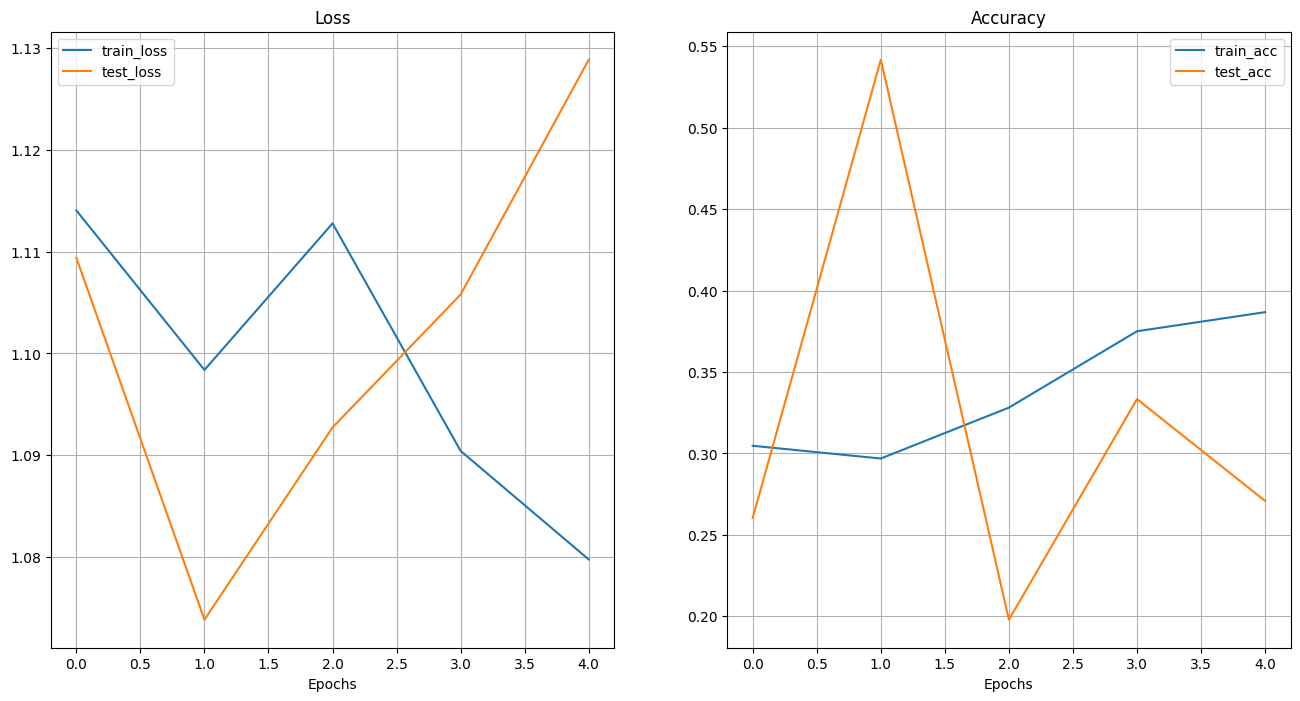

In [57]:
plot_loss_curves(model_0_results)

**test loss-> increase??**

overfitting?


The ideal position for a training and test loss curve is for them to line up closely with each other.

<img src="https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/04-loss-curves-overfitting-underfitting-ideal.jpg" alt="different training and test loss curves illustrating overfitting, underfitting and the ideal loss curves" width="800"/>


### 8. Model 1: TinyVGG with data augmentation

##### => using the same model as before, but with some data augmentation

#### 9.2 Create transform with data augmentation

In [58]:
train_trivialaugment = transforms.Compose([
    transforms.Resize(size=(64,64)),
    # how instance want the sugmentation to happen
    transforms.TrivialAugmentWide(num_magnitude_bins=31),
    transforms.ToTensor()
])

# Don't need to perform augmentation on the test data
test_transforms_simple = transforms.Compose([
    transforms.Resize((64, 64)), 
    transforms.ToTensor()
])

#### 8.2 Create train and test `Datasets` and `DataLoader` with data augmentation

In [60]:
# turn image folder into datasets
train_data_augment = datasets.ImageFolder(root=train_dir,
                                          transform=train_trivialaugment)
test_data_augment = datasets.ImageFolder(root=test_dir,
                                         transform=test_transforms_simple)

train_data_augment, test_data_augment

(Dataset ImageFolder
     Number of datapoints: 225
     Root location: data/pizza_steak_sushi/train
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=warn)
                TrivialAugmentWide(num_magnitude_bins=31, interpolation=InterpolationMode.NEAREST, fill=None)
                ToTensor()
            ),
 Dataset ImageFolder
     Number of datapoints: 75
     Root location: data/pizza_steak_sushi/test
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=warn)
                ToTensor()
            ))

In [61]:
# turn dataseys into dataloaders
BATCH_SIZE = 32
torch.manual_seed(42)

train_dataloader_augment = DataLoader(train_data_augment, BATCH_SIZE, True)
test_dataloader_augment = DataLoader(test_data_augment, BATCH_SIZE, False)

train_dataloader_augment, test_dataloader_augment

(<torch.utils.data.dataloader.DataLoader at 0x157203460>,
 <torch.utils.data.dataloader.DataLoader at 0x1572000a0>)

#### 8.3 Construct and train model 1

##### => using the same model architecture except -> augmented the training data

In [66]:
torch.manual_seed(42)

model_1 = TinyVGG(input_shape=3,
                  hidden_units=10,
                  output_shape=len(train_data_augment.classes))
model_1

TinyVGG(
  (con_block_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (con_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=2250, out_features=3, bias=True)
  )
)

In [67]:
torch.manual_seed(42)

NUM_EPOCHS = 15

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_1.parameters(), lr=0.001)

start_time = timer()
model_1_results = train(model=model_1,
                        train_dataloader=train_dataloader_augment,
                        test_dataloader=test_dataloader_augment,
                        optimizer=optimizer,
                        loss_fn=loss_fn,
                        epochs=NUM_EPOCHS,
                        device="cpu")
end_time = timer()
print(f"Total training time: {end_time - start_time:.3f} seconds.")

  0%|          | 0/15 [00:00<?, ?it/s]

Epoch: 0 | Train Loss: 1.1058 | Train Acc: 0.25 Test Loss: 1.1038 | Test Acc: 0.26
Epoch: 1 | Train Loss: 1.0758 | Train Acc: 0.43 Test Loss: 1.1441 | Test Acc: 0.26
Epoch: 2 | Train Loss: 1.1409 | Train Acc: 0.30 Test Loss: 1.1620 | Test Acc: 0.26
Epoch: 3 | Train Loss: 1.0885 | Train Acc: 0.43 Test Loss: 1.1037 | Test Acc: 0.26
Epoch: 4 | Train Loss: 1.1004 | Train Acc: 0.30 Test Loss: 1.0923 | Test Acc: 0.26
Epoch: 5 | Train Loss: 1.0912 | Train Acc: 0.28 Test Loss: 1.0717 | Test Acc: 0.38
Epoch: 6 | Train Loss: 1.0795 | Train Acc: 0.46 Test Loss: 1.0761 | Test Acc: 0.29
Epoch: 7 | Train Loss: 1.0565 | Train Acc: 0.48 Test Loss: 1.0854 | Test Acc: 0.28
Epoch: 8 | Train Loss: 1.0659 | Train Acc: 0.36 Test Loss: 1.1095 | Test Acc: 0.31
Epoch: 9 | Train Loss: 1.0297 | Train Acc: 0.51 Test Loss: 1.1299 | Test Acc: 0.29
Epoch: 10 | Train Loss: 1.0733 | Train Acc: 0.40 Test Loss: 1.1362 | Test Acc: 0.30
Epoch: 11 | Train Loss: 1.0345 | Train Acc: 0.49 Test Loss: 1.0556 | Test Acc: 0.38
Ep

#### 9.4 Plot train and test loss and accuracy curve

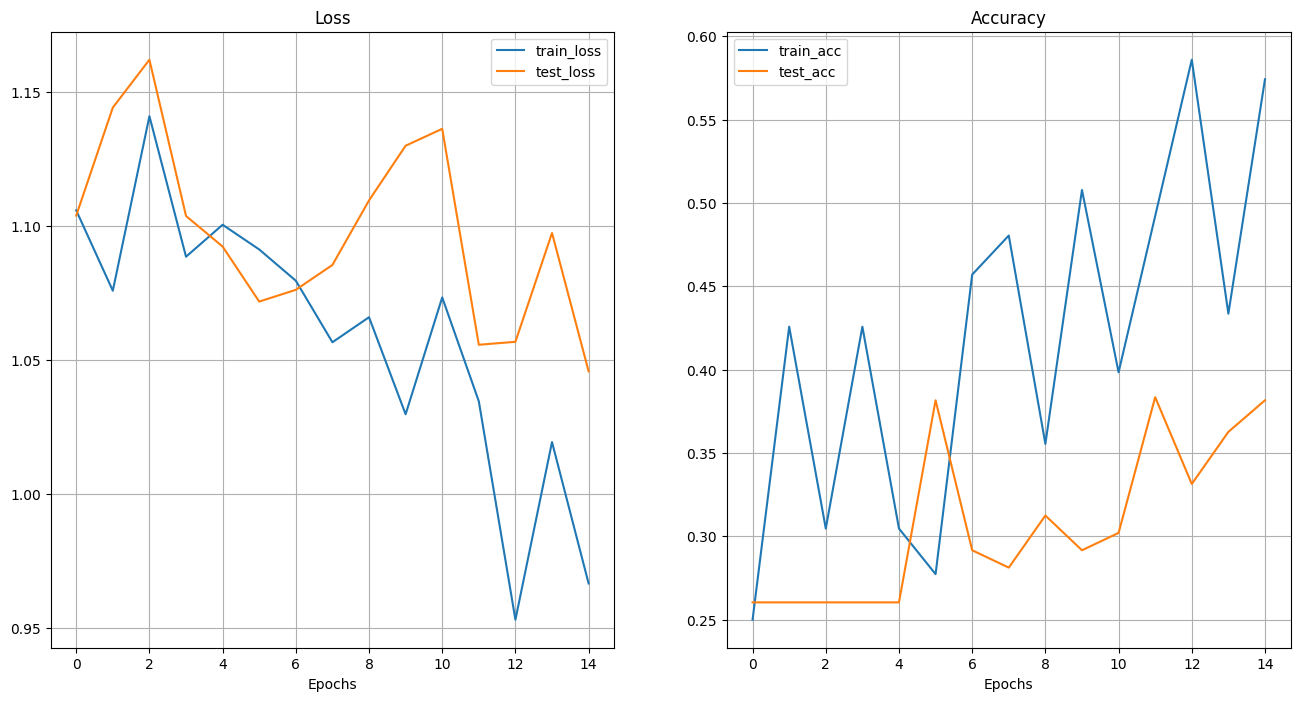

In [68]:
plot_loss_curves(model_1_results)